# Monthly Algorithmic Challenge (October 2023): Sorted List

This post is the fourth in the sequence of monthly mechanistic interpretability challenges. They are designed in the spirit of [Stephen Casper's challenges](https://www.lesswrong.com/posts/KSHqLzQscwJnv44T8/eis-vii-a-challenge-for-mechanists), but with the more specific aim of working well in the context of the rest of the ARENA material, and helping people put into practice all the things they've learned so far.


If you prefer, you can access the Streamlit page [here](https://arena-ch1-transformers.streamlit.app/Monthly_Algorithmic_Problems).

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/sorted-problem.png" width="350">

# Table of Contents
1. [Task & Dataset](#task--dataset)
2. [Setup](#setup)
3. [Attention Patterns](#attention-patterns)
4. [OV circuits](#ov-circuits)
5. [QK circuits](#qk-circuits)
6. [Direct Logit Attribution](#direct-logit-attribution)
7. [Predictions / Adversarial Examples](#predictions--adversarial-examples)
8. [Not Addressed / Open Questions](#not-addressed--open-questions)

## Task & Dataset

The problem for this month is interpreting a model which has been trained to sort a list. The model is fed sequences like:

```
[11, 2, 5, 0, 3, 9, SEP, 0, 2, 3, 5, 9, 11]
```

and has been trained to predict each element in the sorted list (in other words, the output at the `SEP` token should be a prediction of `0`, the output at `0` should be a prediction of `2`, etc).

Here is an example of what this dataset looks like:

## Setup

In [42]:
from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

import os; os.environ["ACCELERATE_DISABLE_RICH"] = "1"
import sys
from typing import List, Tuple, Union, Optional, Callable, Dict
import torch as t
from torch import Tensor
import numpy as np
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from jaxtyping import Float, Int, Bool
from pathlib import Path
import pandas as pd
import circuitsvis as cv
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import utils, ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint
from transformer_lens.components import LayerNorm
import random

t.set_grad_enabled(False)

# Make sure exercises are in the path
chapter = r"chapter1_transformers"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "monthly_algorithmic_problems" / "october23_sorted_list"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from monthly_algorithmic_problems.october23_sorted_list.model import create_model
from monthly_algorithmic_problems.october23_sorted_list.training import train, TrainArgs
from monthly_algorithmic_problems.october23_sorted_list.dataset import SortedListDataset
from plotly_utils import hist, bar, imshow

device = t.device("cuda" if t.cuda.is_available() else "cpu")

MAIN = __name__ == "__main__"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
dataset = SortedListDataset(size=500, list_len=10, max_value=50, seed=43)

print("Sequence = ", dataset[0])
print("Str toks = ", dataset.str_toks[0])

Sequence =  tensor([ 7,  5, 47, 20, 48, 24, 11,  4, 19, 39, 51,  4,  5,  7, 11, 19, 20, 24,
        39, 47, 48])
Str toks =  ['7', '5', '47', '20', '48', '24', '11', '4', '19', '39', 'SEP', '4', '5', '7', '11', '19', '20', '24', '39', '47', '48']


In [24]:
filename = section_dir / "sorted_list_model.pt"
# Check we can load in the model
model = create_model(
    list_len=10,
    max_value=50,
    seed=0,
    d_model=96,
    d_head=48,
    n_layers=1,
    n_heads=2,
    normalization_type="LN",
    d_mlp=None,
    device=device,
)
model.load_state_dict(t.load(filename, map_location=device))

<All keys matched successfully>

In [25]:
# Manually copy `eindex` from lib due to import issues
from typing import Union, List
from collections import defaultdict
import re

def parse_string(input_string: str) -> List[Union[str, List[str]]]:
    # Check for invalid characters
    if re.search(r'[^a-zA-Z0-9_\[\] ]', input_string):
        raise ValueError("Invalid characters detected in the string.")
    
    # Split the string into segments based on square brackets or spaces
    segments = re.findall(r'\[([a-zA-Z0-9_ ]+?)\]|([a-zA-Z0-9_]+)', input_string)
    
    # Process segments into the desired output format
    result = []
    for segment in segments:
        # If segment contains square brackets
        if segment[0]:
            result.append(segment[0].split())
        # If segment is outside square brackets
        elif segment[1]:
            result.append(segment[1])
    
    return result

def eindex(
    *tensors_and_pattern: Union[str, t.Tensor],
    **kwargs,
):
    '''
    Indexing inspired by einops notation: https://einops.rocks/

    
    ==========================================================================================
    ======================================== EXAMPLES ========================================
    ==========================================================================================

    I've given 5 examples here. Most of the code below is annotated with explanations relating it
    to one or more of these examples, to help explain what's going on.

    Some examples:

        # (1) You want to get all the logprobs for correct tokens

            output[batch, seq] = logrobs[batch, seq, labels[batch, seq]]

            pattern = "batch seq [batch seq]"

        # (2a) Same, but d_vocab_out is 2D not 1D for some reason
            
            output[batch, seq] = logrobs[batch, seq, labels[batch, seq, 0], labels[batch, seq, 1]]

            pattern = "batch seq [batch seq 0] [batch seq 1]"
        
        # (2b) Using 2 tensors
            
            output[batch, seq] = logrobs[batch, seq, labels_1[batch, seq], labels_2[batch, seq]]

            pattern = "batch seq [batch seq] [batch seq]"

        # (3) You want to get the logit lens at particular sequence positions (a different seq pos
              for each sequence in the batch)
        
            output[batch, d_vocab] = logprobs[batch, labels[batch], d_vocab]
            
            pattern = "batch [batch] d_vocab"

        # (4) You're indexing into a 2D tensor of tokens, for each destination token you're trying to get 5 source tokens
              (i.e. indices[batch, seqQ, :] = the seqK positions of the top 5 source tokens)
        
            output[batch, seqQ, k] = tokens[batch, indices[batch, seqQ, k]]

            pattern = "batch [batch seqQ k]"

            
    ==========================================================================================
    ======================== ROUGH SUMMARY OF HOW THIS FUNCTION WORKS ========================
    ==========================================================================================

    This is implemented explicitly, i.e. with no built-in PyTorch functions like `gather` (cause they confuse me lol). 
    For example, the way we implement (1) is by creating an index like this:
    
        logprobs[
            t.arange(batch_size).reshape(batch_size, 1),
            t.arange(seq_len).reshape(1, seq_len),
            labels
        ]

    because when you index with tensors across different dimensions, they're all implicitly broadcast together. So we get:

        output[b, s] = logprobs[
            t.arange(batch_size).reshape(batch_size, seq_len)[b, s],
            t.arange(seq_len).reshape(batch_size, seq_len)[b, s],
            labels[b, s]
        ] = logprobs[b, s, labels[b, s]]

    You can use `verbose=True` to print out the dimensions of the shape you'll get at the end.
    '''

    # Unpack and type-check arguments
    arr, *index_tensor_list, pattern = tensors_and_pattern
    verbose = kwargs.pop("verbose", False)
    assert len(kwargs) == 0, f"Unexpected keyword arguments: {kwargs.keys()}"
    assert isinstance(arr, t.Tensor), "First argument must be a tensor."
    assert all(isinstance(i, t.Tensor) for i in index_tensor_list), "All indices must be tensors."
    assert isinstance(pattern, str), "Last argument must be a string."

    # Parse the pattern string into a list of strings and lists
    #   Example #1:  ['batch', 'seq', ['batch', 'seq']]
    #   Example #2a: ['batch', 'seq', ['batch', 'seq', '0'], ['batch', 'seq', '1']]
    pattern_indices = parse_string(pattern)
    pattern_indices_str: List[str] = [p for p in pattern_indices if isinstance(p, str)]
    pattern_indices_list: List[List[str]] = [p for p in pattern_indices if isinstance(p, list)]

    # Check the dimensions are appropriate
    assert len(pattern_indices) == arr.ndim, "Invalid indices. There should be as many terms (strings or square bracket expressions) as there are dims in the first argument (arr)."

    # Check whether you're doing #2a (using a single index with multiple slices) or #2b (using multiple indices), but not both!
    using_multiple_indices = len(index_tensor_list) > 1
    using_multiple_slices = any((isinstance(i, list) and any(j.isdigit() for j in i)) for i in pattern_indices)
    assert not (using_multiple_indices and using_multiple_slices), "You can't use both multiple indices and multiple slices. Choose one or the other."

    # Create a dicionary mapping names of dimensions to their sizes (purely based on the things that appear in square brackets)
    #   Example #1: ['batch', 'seq', ['batch', 'seq']] -> {'batch': batch_size, 'seq': seq_len}
    #   Example #4: ['batch', ['batch', 'seq', 'k']] -> {'batch': batch_size, 'seq': seq_len, 'k': k}
    output_dim_counter = 0
    index_tensor_counter = 0
    dimension_sizes = {}
    for item in pattern_indices:

        # If the item is a string, we just add a single dimension: that of `arr`
        if isinstance(item, str):
            dimension_size = arr.shape[output_dim_counter]
            assert dimension_sizes.get(item, dimension_size) == dimension_size, \
                f"Incompatible dimensions. You've used {item!r} in 2 square bracket expressions, and it has 2 different values in those expressions."
            dimension_sizes[item] = dimension_size
            output_dim_counter += 1

        # If the item is a list, we add multiple dimensions: all those of the appropriate index tensor
        elif isinstance(item, list):
            # Check this square brackets expression matches the indexing tensor that it corresponds to
            assert len(item) == len(index_tensor_list[index_tensor_counter].shape), \
                "Invalid indices. There should be as many terms in each square brackets expression as the corresponding indexing tensor has dimensions."
            # Once you've asserted that it does, add the dimension sizes to the dictionary (checking for contradictions)
            for dimension_name, dimension_size in zip(item, index_tensor_list[index_tensor_counter].shape):
                assert dimension_sizes.get(dimension_name, dimension_size) == dimension_size, \
                    f"Incompatible dimensions. You've used {dimension_name!r} in 2 square bracket expressions, and it has 2 different values in those expressions."
                if not dimension_name.isdigit():
                    dimension_sizes[dimension_name] = dimension_size
            # If >1 index tensor is being used (e.g. #2b), increment the counter so we compare the next square brackets expression to the right indexing tensor
            if using_multiple_indices:
                index_tensor_counter += 1
        
    if verbose:
        print("Dimension sizes:\n  " + "\n  ".join([f"{k}: {v}" for k, v in dimension_sizes.items()]))


    # Get dimensions of output, so we know what to broadcast our indices to (when they're strings). This is all the string expressions (added the first time 
    # they appear), plus the terms in square brackets which don't also appear in string expressions (e.g. as in #4).
    #   Example #1: ['batch', 'seq', ['batch', 'seq']] -> ['batch', 'seq']
    #   Example #4: ['batch', ['batch', 'seq', 'k']] -> ['batch', 'seq', 'k']
    output_dims = []
    output_shape = []
    for item in pattern_indices:
        if isinstance(item, str):
            output_dims.append(item)
            output_shape.append(dimension_sizes[item])
        elif isinstance(item, list):
            for dim_name in item:
                if (dim_name not in pattern_indices_str) and (dim_name not in output_dims) and not(dim_name.isdigit()):
                    output_dims.append(dim_name)
                    output_shape.append(dimension_sizes[dim_name])
    output_shape = tuple(output_shape)
    output_ndim = len(output_shape)
        

    # Start constructing the index `full_idx`, by appending t.arange objects or tensors to it
    output_dim_counter = 0
    index_tensor_counter = 0
    full_idx = []
    for (item, dim_size) in zip(pattern_indices, arr.shape):

        # ! If item in pattern string is just a str, we put a rearranged indices tensor here so it can broadcast with the index tensors
        #   Example #1: 'batch' -> t.arange(batch_size).reshape(batch_size, 1)
        #   Example #1: 'seq'   -> t.arange(seq_len).reshape(1, seq_len)
        #   Example #4: 'batch' -> t.arange(batch_size).reshape(batch_size, 1, 1)
        
        if isinstance(item, str):
            shape = [1] * output_ndim
            shape[output_dim_counter] = dim_size
            output_dim_counter += 1
            # ! Append the broadcasted t.arange object to the full list of indices
            full_idx.append(t.arange(dim_size).reshape(*shape))
        
        # ! If item is a list, this means we should be indexing into the corresponding index tensor
        # i.e. we need to construct `idx` and `shape` s.t. index_tensor[idx].reshape(shape) is the thing we want to append to the `full_idx` list
        #   Example #1:  ['batch', 'seq']      -> we want indices[:, :]
        #   Example #2a: ['batch', 'seq', '0'] -> we want indices[:, :, 0]
        #   Example #3:  ['batch']             -> we want indices[:].reshape(batch_size, 1) so it broadcasts with the final output shape
        
        elif isinstance(item, list):
        
            # Get the correct indices tensor, and increment the counter if we're using multiple indices
            index_tensor = index_tensor_list[index_tensor_counter]
            if using_multiple_indices:
                index_tensor_counter += 1
        
            # Get `idx` we'll be using to index our tensor - this will involve either slice(None) or taking a slice e.g. in Example #2a
            idx = [int(i) if i.isdigit() else slice(None) for i in item]
        
            # Get `shape` we'll be using to broadcast our tensor back out to the shape of final output. This is necessary if the indexing
            # tensor has fewer dims than the final output, e.g. Example #3. We do this by taking the output shape, and replacing the elements
            # with 1s if they're not dimensions that already exist in `index_tensor[idx]`.
            shape = list(output_shape)
            for dim_idx, dim_name in enumerate(output_dims):
                if dim_name not in item:
                    shape[dim_idx] = 1
            assert t.tensor(shape).prod().item() == index_tensor[idx].numel(), \
                "Something's gone wrong with the shape broadcasting. Please submit an issue at https://github.com/callummcdougall/eindex"
            # ! Append the reshaped index tensor to the full list of indices
            full_idx.append(index_tensor[idx].reshape(*shape))

    return arr[full_idx]

## Attention Patterns

In [26]:
# Use clearly patterned examples to simplify attention pattern analysis
dataset.toks[0] = t.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 51, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dataset.toks[1] = t.tensor([10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 51, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dataset.toks[2] = t.tensor([*range(1, 30, 3), 51, *range(1, 30, 3)])
dataset.toks[3] = t.tensor([*range(30, 1, -3), 51, *range(3, 33, 3)])
dataset.toks[4] = t.tensor([*range(6, 11), *range(1, 6), 51, *range(1, 11)])
dataset.toks[5] = t.tensor([*range(26, 36), 51, *range(26, 36)])
dataset.toks[6] = t.tensor([*range(35, 25, -1), 51, *range(26, 36)])
dataset.toks[7] = t.tensor([*range(41, 51), 51, *range(41, 51)])
dataset.toks[8] = t.tensor([*range(50, 40, -1), 51, *range(41, 51)])
dataset.toks[9] = t.tensor([*range(44, 34, -1), 51, *range(35, 45)])
dataset.toks[10] = t.tensor([*range(30, 35), *range(45, 50), 51, *range(30, 35), *range(45, 50)])

dataset.str_toks[0] = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'SEP', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
dataset.str_toks[1] = ['10', '9', '8', '7', '6', '5', '4', '3', '2', '1', 'SEP', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
dataset.str_toks[2] = [str(i) for i in range(1, 30, 3)] + ['SEP'] + [str(i) for i in range(1, 30, 3)]
dataset.str_toks[3] = [str(i) for i in range(30, 1, -3)] + ['SEP'] + [str(i) for i in range(3, 33, 3)]
dataset.str_toks[4] = [str(i) for i in range(6, 11)] + [str(i) for i in range(1, 6)] + ['SEP'] + [str(i) for i in range(1, 11)]
dataset.str_toks[5] = [str(i) for i in range(26, 36)] + ['SEP'] + [str(i) for i in range(26, 36)]
dataset.str_toks[6] = [str(i) for i in range(35, 25, -1)] + ['SEP'] + [str(i) for i in range(26, 36)]
dataset.str_toks[7] = [str(i) for i in range(41, 51)] + ['SEP'] + [str(i) for i in range(41, 51)]
dataset.str_toks[8] = [str(i) for i in range(50, 40, -1)] + ['SEP'] + [str(i) for i in range(41, 51)]
dataset.str_toks[9] = [str(i) for i in range(44, 34, -1)] + ['SEP'] + [str(i) for i in range(35, 45)]
dataset.str_toks[10] = [str(i) for i in range(30, 35)] + [str(i) for i in range(45, 50)] + ['SEP'] + [str(i) for i in range(30, 35)] + [str(i) for i in range(45, 50)]

for i in range(11):
    dataset.str_toks[i] = [s + " " if idx != len(dataset.str_toks[i]) - 1 else s for idx, s in enumerate(dataset.str_toks[i])]


In [27]:
logits, cache = model.run_with_cache(dataset.toks)
logits: Tensor = logits[:, dataset.list_len:-1, :]

targets = dataset.toks[:, dataset.list_len+1:]

logprobs = logits.log_softmax(-1) # [batch seq_len vocab_out]
probs = logprobs.softmax(-1)

batch_size, seq_len = dataset.toks.shape
logprobs_correct = eindex(logprobs, targets, "batch seq [batch seq]")
probs_correct = eindex(probs, targets, "batch seq [batch seq]")

avg_cross_entropy_loss = -logprobs_correct.mean().item()

print(f"Average cross entropy loss: {avg_cross_entropy_loss:.3f}")
print(f"Mean probability on correct label: {probs_correct.mean():.3f}")
print(f"Median probability on correct label: {probs_correct.median():.3f}")
print(f"Min probability on correct label: {probs_correct.min():.3f}")

cv.attention.from_cache(
    cache = cache,
    tokens = dataset.str_toks,
    batch_idx = list(range(12)),
    radioitems = True,
    return_mode = "view",
    mode = "small",
)

Average cross entropy loss: 0.045
Mean probability on correct label: 0.962
Median probability on correct label: 0.980
Min probability on correct label: 0.001


* Head 0.0 distinctively self-attends after the SEP token for all numbers outside the ~28-30 range, whereas Head 0.1 does not self-attend after the SEP token
* The attention patters are more distinct for numbers smaller numbers such as 1-10, and more diffuse for larger numbers such as 41-50, possibly due to the model using relative difference between numbers to determine its predictions. Also supporting this is that the attention pattern for range(1, 30, 3) is more distinct than the attention pattern for range(1, 11)
* Head 0.1's attention pattern for range(1, 11) closely matches Head 0.0's attention pattern for range(26, 36) including the fact that self-attending does not happen for Head 0.0 in this range, indicating that the numbers may at times be implementing the same algorithm for different numbers
* For numbers outside of Head 0.0's domain of ~28-35 (and maybe 0-2) it appears to be acting as a negative copying circuit that inhibits wrong guesses such as the current token and numbers slightly smaller than it
* For numbers in a heads' domain (ie ~0-2, ~28-35 for Head 0.0 and outside that for Head 0.1) each head seems to be paying attention to which tokens could plausibly come next with a magnitude that matches how likely each number is to be next. It tends to becomes more "confident" and attends more strongly to to fewer numbers when predicting which numbers go either the start or end of the target sequence

## OV circuits

In [28]:
scale_final = cache["scale"][:, :, 0][:, 1:].mean()
scale_0 = cache["scale", 0, "ln1"][:, 1:].mean()
W_OV = model.W_V @ model.W_O
W_E = model.W_E
W_U = model.W_U

# ! Get direct path
W_E_OV_direct = (W_E / scale_final) @ W_U

# ! Get full OV matrix for path through just layer 0
W_E_OV_0 = (W_E / scale_0) @ W_OV[0]
W_OV_0_full = (W_E_OV_0 / scale_final) @ W_U # [head1 vocab_in vocab_out]



# Stick 'em together
assert W_OV_0_full.shape == (2, 52, 52)
assert W_E_OV_direct.shape == (52, 52)
W_OV_full_all = t.cat([
    t.cat([W_E_OV_direct[None, None], W_OV_0_full[:, None]]), # [head0 1 vocab_in vocab_out]
], dim=1) # [head0 head1 vocab_in vocab_out]
assert W_OV_full_all.shape == (3, 1, 52, 52)

components_0 = ["W<sub>E</sub>"] + [f"0.{i}" for i in range(2)]

imshow(
    W_OV_full_all.transpose(0, 1).flatten(0, 1), # .softmax(dim=-1),
    facet_col = 0,
    facet_col_wrap = 1,
    facet_labels = [" ➔ ".join(list(dict.fromkeys(["W<sub>E</sub>", c0, "W<sub>U</sub>"]))) for c0 in components_0],
    title = f"Full virtual OV circuits",
    x = dataset.vocab,
    y = dataset.vocab,
    labels = {"x": "Source", "y": "Dest"},
    height = 1200,
    width = 1200,
    # text = text,
)


* Head 0.0 and 0.1 have split responsiblity for different numbers, and implement similar logic
    * Head 0.0 is a positive copying heads for numbers ~28-36 and Head 0.1 is a positive copying head for numbers outside this range. Notably, the positive copying circuit is slightly positive for destination tokens that are slightly greater than the source token because these represent valid potential next tokens, but it is slightly negative for destination tokens that are slightly smaller than the source token since these will never be correct next tokens.
        * Outside of the ~38-36 range, Head 0.0 acts as a slightly negative copying circuit
    * Because Head 0.0 it is responsible for fewer numbers than Head 0.1, Head 0.0 can attend more closely to numbers in its range and therefore has a more narrow band outside of which it will start strongly inhibiting destination tokens (~ greater than +/- 5 from the source token, whereas for Head 0.1 this band is ~ greater than +/- 10 from the source token)
    * The model has likely split the responsiblity for sorting different numbers to more efficiently use model resources. It is also notable that the model  split the responsibility of the numbers ~roughly~ in the middle. This makes sense as it is easier to differentiate for numbers that are much larger and much smaller, so this is better for the model that head 0.0 being responsible for the very smallest or very largest numbers. It is possible this split is actually due to something else around how the model is representing numbers, but this explanation seems explausible.


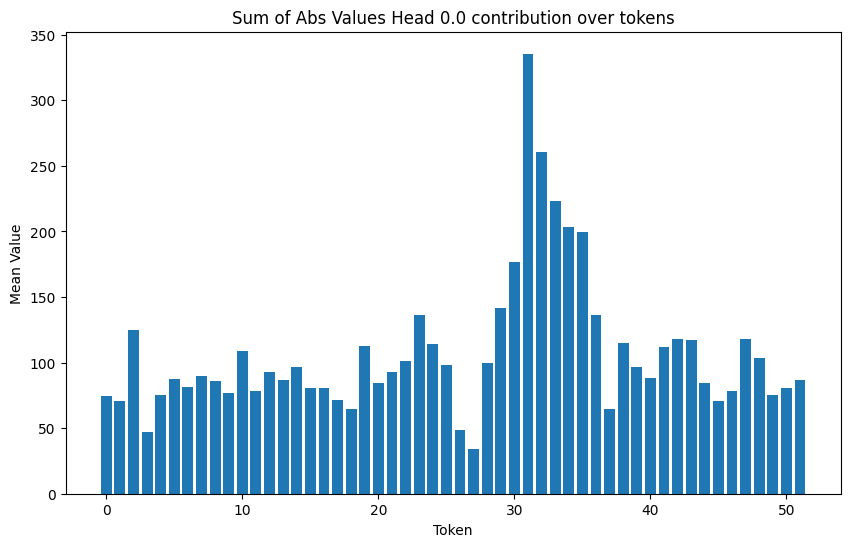

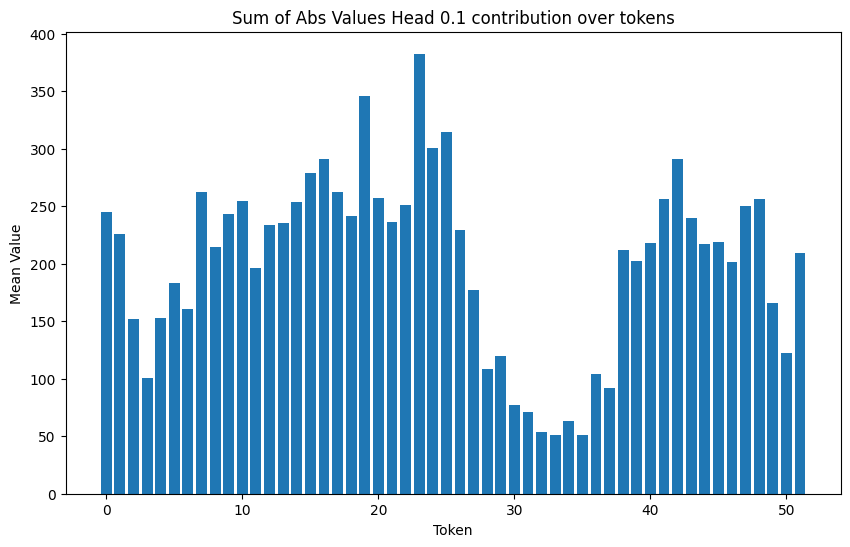

In [29]:
# Head 0
abs_head_0_logits = W_OV_0_full[0].abs().sum(dim=1)

plt.figure(figsize=(10, 6))
plt.bar(np.arange(abs_head_0_logits.shape[0]), abs_head_0_logits)
plt.xlabel('Token')
plt.ylabel('Mean Value')
plt.title('Sum of Abs Values Head 0.0 contribution over tokens')


# Head 1
abs_head_1_logits = W_OV_0_full[1].abs().sum(dim=1)

plt.figure(figsize=(10, 6))
plt.bar(np.arange(abs_head_1_logits.shape[0]), abs_head_1_logits)
plt.xlabel('Token')
plt.ylabel('Mean Value')
plt.title('Sum of Abs Values Head 0.1 contribution over tokens')
plt.show()


* Visual plot above shows that Head 0.1 does in fact contribute more strongly than Head 0.0 for most numbers outside the ~27-37 range

## QK circuits

In [30]:
W_pos_labels = [str(i) + " - pos" for i in range(model.cfg.n_ctx)]

# Check layernorm scale factor mean & std dev, verify that std dev is small
scale = cache["scale", 0, "ln1"][:, :, 0, 0] # shape (batch, seq)
df = pd.DataFrame({
    "std": scale.std(0).cpu().numpy(),
    "mean": scale.mean(0).cpu().numpy(),
})
px.bar(
    df, 
    title="Mean & std of layernorm before first attn layer", 
    template="simple_white", width=600, height=400, barmode="group"
).show()

W_QK: Tensor = model.W_Q[0] @ model.W_K[0].transpose(-1, -2) / (model.cfg.d_head ** 0.5)

W_E_scaled = model.W_E / scale.mean()
W_pos_scaled = model.W_pos / scale.mean(dim=0).unsqueeze(-1)

W_Qemb_Kemb = W_E_scaled @ W_QK @ W_E_scaled.T
W_Qboth_Kpos = t.concat([W_E_scaled, W_pos_scaled]) @ W_QK @ W_pos_scaled.T
# Apply causal masking
W_Qboth_Kpos[:, -len(W_pos_labels):].masked_fill_(t.triu(t.ones_like(W_Qboth_Kpos[:, -len(W_pos_labels):]), diagonal=1).bool(), float("-inf"))

imshow(
    W_Qemb_Kemb,
    facet_col = 0,
    facet_labels = [f"0.{head}" for head in range(model.cfg.n_heads)],
    title = f"Query = W<sub>E</sub>, Key = W<sub>E</sub>",
    labels = {"x": "Source", "y": "Dest"},
    x = dataset.vocab,
    y = dataset.vocab,
    height = 400,
    width = 750,
)
imshow(
    W_Qboth_Kpos,
    facet_col = 0,
    facet_labels = [f"0.{head}" for head in range(model.cfg.n_heads)],
    title = f"Query = W<sub>E</sub> & W<sub>pos</sub>, Key = W<sub>pos</sub>",
    labels = {"x": "Source", "y": "Dest"},
    x = W_pos_labels,
    y = dataset.vocab + W_pos_labels,
    height = 620,
    width = 1070,
)

* Head 0.1 has much stronger activations than 0.0 for QK against the embedding weight matrix, however they are very similar in terms of their cell highlight patterns. Where they become different is in taking into account Wpos. While the pos enc inclusive pattern is roughly the same before the SEP token, again with 0.1 having stronger weighting than 0.0 overall, the positional encoder appears to "flip" the sign for each of these after SEP token. From the SEP token on, they have similar magnitudes and opposite signs.

## Direct Logit Attribution

In [31]:
def dla_imshow(
    dataset: SortedListDataset,
    cache: ActivationCache,
    batch_idx: int,
    str_tok: Union[str, List[str]],
    subtract_mean: Union[bool, Tensor] = True,
):
    # ! Get DLA from the direct paths & paths through just heads in layer 0
    resid_decomposed = t.stack([
        cache["embed"] + cache["pos_embed"],
        *[cache["result", 0][:, :, head] for head in range(2)]  # Change here for 2 attn head
    ], dim=1)
    assert resid_decomposed.shape == (len(dataset), 3, 21, model.cfg.d_model), resid_decomposed.shape  # Change here for 2 attn head
    t.testing.assert_close(resid_decomposed.sum(1) + model.b_O[0], cache["resid_post", 0])

    dla = (resid_decomposed / cache["scale"].unsqueeze(1)) @ model.W_U
    assert dla.shape == (len(dataset), 3, 21, model.cfg.d_vocab), dla.shape  # Change here for 2 attn head

    # ! Get DLA for batch_idx, subtract mean baseline, optionally return the mean
    dla_mean = dla.mean(0)
    if isinstance(subtract_mean, Tensor):
        dla = dla[batch_idx] - subtract_mean
    elif subtract_mean:
        dla = dla[batch_idx] - dla_mean
    else:
        dla = dla[batch_idx]

    # ! Plot everything
    if isinstance(str_tok, str):
        str_tok = [str_tok]
        kwargs = dict(
            title = f"Direct Logit Attribution by path, for token {str_tok[0]!r}",
            height = 550,
            width = 700,
        )
    else:
        assert len(str_tok) % 2 == 0, "Odd numbers mess up figure order for some reason"
        kwargs = dict(
            title = "Direct Logit Attribution by path",
            facet_col = -1,
            facet_labels = [f"DLA for token {s!r}" for s in str_tok],
            height = 100 + 450 * int(len(str_tok) / 2),
            width = 1250,
            facet_col_wrap = 1,
        )
    toks = [dataset.vocab.index(tok) for tok in str_tok]
    layer0 = [" "] + [f"0.{i} " for i in range(2)]  # Change here for 2 attn head
    imshow(
        dla[:, :, toks].squeeze(),
        x = [f"{s}<br><sub>({i})</sub>" for i, s in enumerate(dataset.str_toks[batch_idx])],
        y = layer0,
        # margin = dict.fromkeys("tblr", 40),
        aspect = "equal",
        text_auto = ".0f",
        **kwargs,
    )
    if isinstance(subtract_mean, bool) and subtract_mean:
        return dla_mean


batch_idx = 10
actual = t.argmax(logits[batch_idx], dim=1).tolist()
print(f"Seq = {' '.join(dataset.str_toks[batch_idx][:10])}, Target = {' '.join(dataset.str_toks[batch_idx][-10:])}, Actual = {actual}")

dla_mean = dla_imshow(
    dataset,
    cache,
    batch_idx = batch_idx, 
    str_tok = ["30", "45"],
    subtract_mean = True,
)

Seq = 30  31  32  33  34  45  46  47  48  49 , Target = 30  31  32  33  34  45  46  47  48  49, Actual = [45, 31, 32, 33, 34, 45, 46, 47, 48, 49]


* The DLA is in accordance with the above assessment that the head's roles / relevance vary within separate ranges
* In this example, the model incorrectly predicts that 45 is the first token. It is in fact the first token within the numbers relevant to Head 0.1's domain, so Head 0.1 contributes strongly to predicting '45' at the SEP token position, but this was incorrect due to information outside the scope of what it focuses on.
* For numbers within Head 0.0's domain (~28-35) where it largely acts as a positive copying circuit, the head positively contributes to the model prediction. For numbers outside this range in this example, Head 0.0 contributes slightly negatively to the prediction 

## Predictions / Adversarial Examples

* Head 0.1 seems to weight its predictions more heavily than Head 0.0. Because they are responsible for different numbers, we can likely introduce an adversarial "important" in that it tends to have a greater impact on the numbers, therefore predictable failure where 5 of the numbers are comfortably within Head 0.0's domain (ie, 28-33) and the other half are comfortably within Head 0.1's domain (ie, 45-50)
    * **Head 0.1 Overconfidence Failure** - I predict the model will fail at the first token because it will use Head 0.1's prediction. I predict this issue will not happen when the 5 numbers in Head 0.1's domain are less than the numbers in Head 0.0's domain 
* In addition to failing when jumping between the range of numbers in Head 0.0's domain and Head 0.1's, the OV circuits show that the model has learned to inhibit destination tokens that are significantly larger than the source token even if it is possible they could follow it. This may be due to the fact that the dataset is relatively small (500 examples) and the larger the "jump", the less likely it is to occur in the dataset given that the other numbers would have to be from smaller ranges since they could not be within the set that was skipped by the jump.
    * **Large Jump Failure** - I predict that the model will struggle with large jumps (>10) between numbers regardless of the numbers used. Additionally, I predict that Head 0.0 will struggle with even smaller jumps (>5) when Head 0.1 is ablated
* Head 0.1 appears to contribute more significantly to the residual stream and appears to be responsible for a larger range of numbers
    * **Key Head 0.1 Failure** - I predict zero-ablating it will have a larger overall negative impact on loss than zero-ablating Head 0.0
* The model appears to have fuzzier attention patterns when the numbers have smaller relative differences (ie, more fuzzy when numbers 41-50 are being sorted than when 1-10 are being sorted)
    * **Relative Difference Failure** - I predict that the model is using the relative difference between numbers to sort them, and will struggle more with sorting numbers that have smaller relative differences and vice versa

#### Head 0.1 Overconfidence Failure


In [32]:
# Create the dataset
head_0_1_overconfidence_data = t.empty(0)
head_0_1_domain = range(40, 51)
head_0_0_domain = range(27, 35)
for _ in range(100):
    first_half = random.sample(head_0_0_domain, 5)
    second_half = random.sample(head_0_1_domain, 5)
    tensor = t.tensor([first_half + second_half + [51.0] + sorted(first_half + second_half)])
    head_0_1_overconfidence_data = t.cat((head_0_1_overconfidence_data, tensor), 0)
head_0_1_overconfidence_data = head_0_1_overconfidence_data.to(t.int64)
print(head_0_1_overconfidence_data.shape, head_0_1_overconfidence_data[0])

torch.Size([100, 21]) tensor([31, 34, 28, 29, 30, 49, 46, 43, 50, 45, 51, 28, 29, 30, 31, 34, 43, 45,
        46, 49, 50])


[0.09000000357627869, 0.75, 1.0, 0.9900000095367432, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


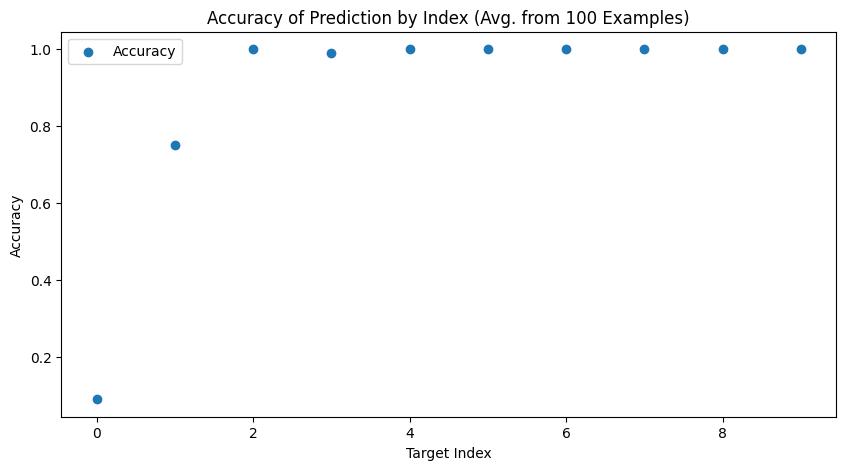

In [33]:
head_0_1_overconfidence_logits, head_0_1_overconfidence_cache = model.run_with_cache(head_0_1_overconfidence_data)
head_0_1_overconfidence_logits: Tensor = head_0_1_overconfidence_logits[:, dataset.list_len:-1, :]

head_0_1_overconfidence_targets = head_0_1_overconfidence_data[:, dataset.list_len+1:]

accuracy = (t.argmax(head_0_1_overconfidence_logits, dim=-1) == head_0_1_overconfidence_targets).float().mean(dim=0)
print(accuracy.tolist())

plt.figure(figsize=(10, 5))
plt.scatter(range(10), accuracy.tolist(), label='Accuracy')  # Changed plot to scatter for dot chart
plt.xlabel('Target Index')
plt.ylabel('Accuracy')
plt.title('Accuracy of Prediction by Index (Avg. from 100 Examples)')
plt.legend()
plt.show()


* As anticipated, the model gets the first prediction wrong the majority of the time (~90% of the time) under this scheme due to Head 0.1's strong confidence in the smallest number it finds in its domain being first. This is understandable, as the majority of the time in the training data the smallest number in Head 0.1's domain of ~<26 and ~>35 would be likely to come first, as it would mean all other numbers would have to be greater than ~26.

#### Large Jump Failure

In [34]:
large_jump_domain_1 = range(18)
large_jump_domain_2 = range(32, 51)
large_jump_data = t.empty((0, 21))  # Initialize large_jump_data with correct shape
for _ in range(100):
    first_half = random.sample(large_jump_domain_1, 5)
    second_half = random.sample(large_jump_domain_2, 5)
    seq = first_half + second_half
    random.shuffle(seq)
    tensor = t.tensor([seq + [51.0] + sorted(seq)])
    large_jump_data = t.cat((large_jump_data, tensor), 0)
large_jump_data = large_jump_data.to(t.int64)
print(large_jump_data.shape, large_jump_data[0])


torch.Size([100, 21]) tensor([34,  1, 40, 10, 38, 43,  6, 13, 12, 33, 51,  1,  6, 10, 12, 13, 33, 34,
        38, 40, 43])


In [35]:
large_jump_logits = model(large_jump_data)
large_jump_logits: Tensor = large_jump_logits[:, dataset.list_len:-1, :]
large_jump_targets = large_jump_data[:, dataset.list_len+1:]

large_jump_logprobs = large_jump_logits.log_softmax(-1)
large_jump_logprobs_correct = eindex(large_jump_logprobs, large_jump_targets, "batch seq [batch seq]")
large_jump_loss = -large_jump_logprobs_correct.mean().item()

print('Large Jump Avg Cross Entropy Loss:', large_jump_loss)
print(f"Original Avg Cross Entropy Loss: {avg_cross_entropy_loss:.3f}")

percentage_difference = ((large_jump_loss - avg_cross_entropy_loss) / avg_cross_entropy_loss) * 100
print()
print(f"Large Jump Avg Loss is {percentage_difference:.2f}% greater than the Original Average Cross Entropy Loss")



Large Jump Avg Cross Entropy Loss: 0.06583957374095917
Original Avg Cross Entropy Loss: 0.045

Large Jump Avg Loss is 46.06% greater than the Original Average Cross Entropy Loss


* The average cross entropy loss for large jumps is ~0.65, which is ~50% more than the original CEL, indicating that the model does in fact struggle more with larger jumps as the OV circuits suggested

#### Relative Difference Failure

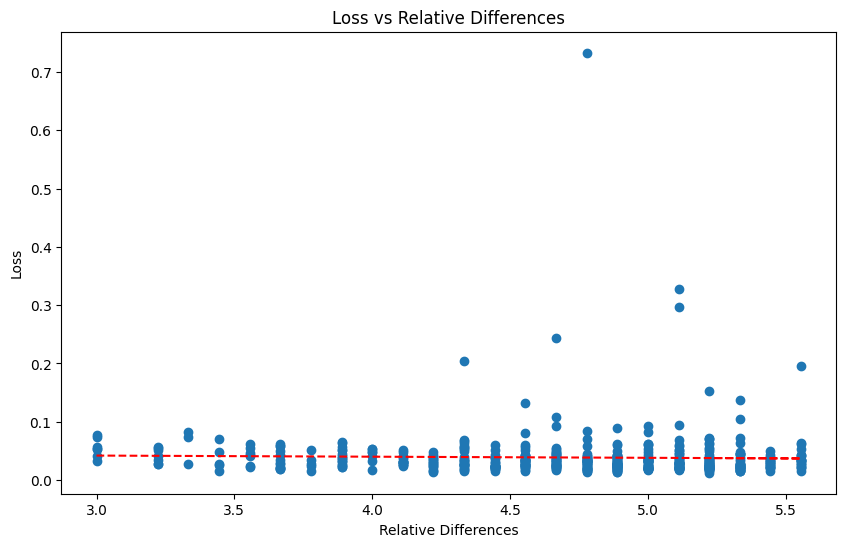

In [36]:
losses = -logprobs_correct.mean(dim=1).detach().numpy()
relative_diffs = []
relative_diffs_losses = []
for i, sample in enumerate(dataset.toks):
    sorted_sample = sorted(sample[-10:])
    diffs = [sorted_sample[i+1] - sorted_sample[i] for i in range(len(sorted_sample)-1)]
    relative_diff = sum(diffs)/len(diffs)
    if relative_diff >= 2.5: # remove outliers
        relative_diffs.append(relative_diff)
        relative_diffs_losses.append(losses[i])

# Plotting the relative diffs on the x axis against the loss on the y axis
plt.figure(figsize=(10, 6))
plt.scatter(relative_diffs, relative_diffs_losses)

# Adding a trendline to the chart
z = np.polyfit(relative_diffs, relative_diffs_losses, 1)
p = np.poly1d(z)
plt.plot(relative_diffs, p(relative_diffs), "r--")

plt.xlabel('Relative Differences')
plt.ylabel('Loss')
plt.title('Loss vs Relative Differences')
plt.show()


* This prediction turns out to be **false**, since there is no apparent relationship between the relative difference between the numbers and the loss. While the attention patterns were "cleaner" / more simple and concentrated for the examples I plotted with larger relative differences, I only plotted a small number of examples and also only included ones with even spacing between the numbers, which is more artificial case that would be less likely to show up in the dataset

#### Head 0.1 Ablation Failure

In [37]:
layer_to_ablate = 0
head_index_to_ablate = 0

def head_0_ablation_hook(
    value: Float[t.Tensor, "batch pos head_index d_head"],
    hook: HookPoint
) -> Float[t.Tensor, "batch pos head_index d_head"]:
    value[:, :, 0, :] = 0.
    return value

head_0_ablated_logits = model.run_with_hooks(
    dataset.toks, 
    return_type="logits", 
    fwd_hooks=[(
        utils.get_act_name("v", layer_to_ablate), 
        head_0_ablation_hook
        )]
    )
head_0_ablated_logits: Tensor = head_0_ablated_logits[:, dataset.list_len:-1, :]

head_0_ablated_logprobs = head_0_ablated_logits.log_softmax(-1)
batch_size, seq_len = dataset.toks.shape
head_0_ablated_logprobs_correct = eindex(head_0_ablated_logprobs, targets, "batch seq [batch seq]")


In [38]:
layer_to_ablate = 0
head_index_to_ablate = 1

def head_1_ablation_hook(
    value: Float[t.Tensor, "batch pos head_index d_head"],
    hook: HookPoint
) -> Float[t.Tensor, "batch pos head_index d_head"]:
    value[:, :, 1, :] = 0.
    return value

head_1_ablated_logits = model.run_with_hooks(
    dataset.toks, 
    return_type="logits", 
    fwd_hooks=[(
        utils.get_act_name("v", layer_to_ablate), 
        head_1_ablation_hook
        )]
    )
head_1_ablated_logits: Tensor = head_1_ablated_logits[:, dataset.list_len:-1, :]

head_1_ablated_logprobs = head_1_ablated_logits.log_softmax(-1)
batch_size, seq_len = dataset.toks.shape
head_1_ablated_logprobs_correct = eindex(head_1_ablated_logprobs, targets, "batch seq [batch seq]")


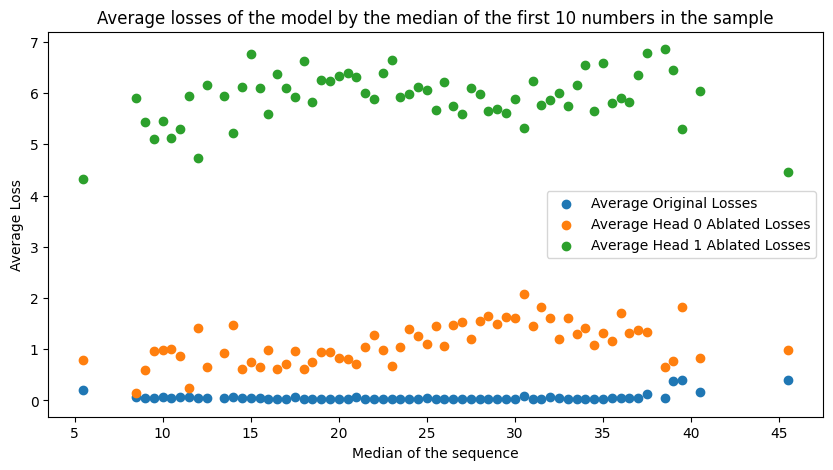

In [39]:
losses = -logprobs_correct.mean(dim=1).detach().numpy()
head_0_ablated_losses = -head_0_ablated_logprobs_correct.mean(dim=1).detach().numpy()
head_1_ablated_losses = -head_1_ablated_logprobs_correct.mean(dim=1).detach().numpy()
medians = np.median(dataset[:, :10].numpy(), axis=1)

unique_medians = np.unique(medians)
avg_losses = [np.mean(losses[medians == median]) for median in unique_medians]
avg_head_0_ablated_losses = [np.mean(head_0_ablated_losses[medians == median]) for median in unique_medians]
avg_head_1_ablated_losses = [np.mean(head_1_ablated_losses[medians == median]) for median in unique_medians]

plt.figure(figsize=(10, 5))
plt.scatter(unique_medians, avg_losses, label='Average Original Losses')
plt.scatter(unique_medians, avg_head_0_ablated_losses, label='Average Head 0 Ablated Losses')
plt.scatter(unique_medians, avg_head_1_ablated_losses, label='Average Head 1 Ablated Losses')
plt.xlabel('Median of the sequence')
plt.ylabel('Average Loss')
plt.title('Average losses of the model by the median of the first 10 numbers in the sample')
plt.legend()
plt.show()


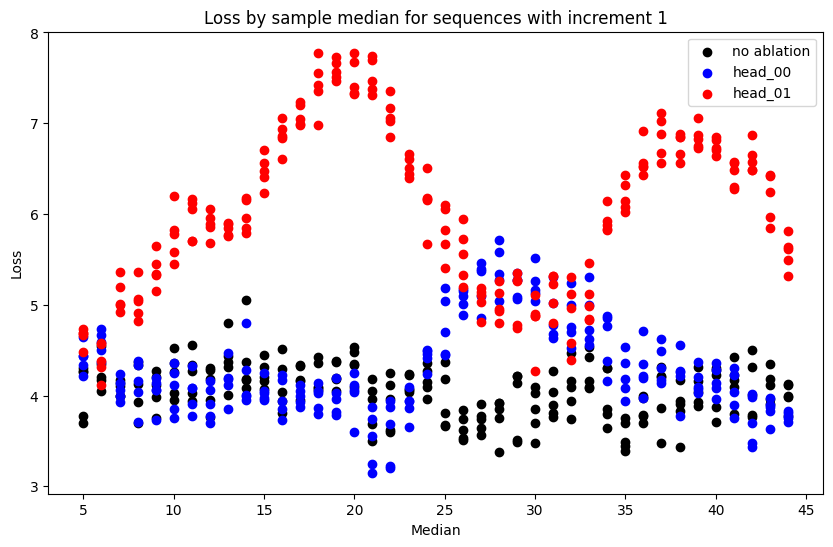

In [40]:
test_dataset = []
for i in range(1, 41):
    for _ in range(5):
        random_list = list(range(i, i+10))
        random.shuffle(random_list)
        ordered_list = list(range(i, i+10))
        test_dataset.append(random_list + [51] + ordered_list)

test_dataset_tensor = t.tensor(test_dataset)

losses_and_medians_no_ablation = []
losses_and_medians_head_00 = []
losses_and_medians_head_01 = []
for sample in test_dataset_tensor:
    median = sample[:10].median().item()
    
    loss = model(sample.unsqueeze(0), return_type="loss")
    losses_and_medians_no_ablation.append((loss.item(), median))

    head_00_ablated_loss = model.run_with_hooks(
        sample.unsqueeze(0), 
        return_type="loss", 
        fwd_hooks=[(
            utils.get_act_name("v", 0), 
            head_0_ablation_hook
            )]
        )
    losses_and_medians_head_00.append((head_00_ablated_loss.item(), median))
    
    head_01_ablated_loss = model.run_with_hooks(
        sample.unsqueeze(0), 
        return_type="loss", 
        fwd_hooks=[(
            utils.get_act_name("v", 0), 
            head_1_ablation_hook
            )]
        )
    losses_and_medians_head_01.append((head_01_ablated_loss.item(), median))

    
losses, medians = zip(*losses_and_medians_no_ablation)
losses_00, medians_00 = zip(*losses_and_medians_head_00)
losses_01, medians_01 = zip(*losses_and_medians_head_01)

plt.figure(figsize=(10, 6))
plt.scatter(medians, losses, color='black', label='no ablation')
plt.scatter(medians_00, losses_00, color='blue', label='head_00')
plt.scatter(medians_01, losses_01, color='red', label='head_01')
plt.title("Loss by sample median for sequences with increment 1")
plt.xlabel('Median')
plt.ylabel('Loss')
plt.legend()
plt.show()



* Interestingly, while there does not appear to be a clear pattern in the loss by head ablation and median in the previous chart, in the above chart when the numbers passed to the model are of a range with an increment of 1 the head domain by number pattern emerges. This is likely because incrementing by 1 more closely bounds the numbers in the sequences in a tight range which makes each head's range domain more evident, while median alone does not control for this. This chart shows the same number range responsibilities by head as the other charts and continues to confirm that Head 0.1 is generally more important for reducing loss. For numbers outside its ~27-35 range, Head 0.0 often doesn't even improve the loss and sometimes hurts it.

## Not Addressed / Open Questions
* What's the internal "representation scheme" for these numbers (ie fourier transform implementation in modular addition paper)?
* Weight decay resulted in sparsity for the weights in various components, any idea what these represent, in particular the embedding dimensions?

In [41]:
# Display of the sparsity in model compenents that was encouraged by weight decay

imshow( 
    model.W_U.T,
    title = "Unembedding matrix",
    height = 300,
    width = 700,
)
imshow(
    model.W_E,
    title = "Embedding matrix",
    height = 300,
    width = 700,
)
imshow(
    model.W_K.view(96, 96),
    title = "W_K matrix",
    height = 400,
    width = 600,
)
imshow(
    model.W_Q.view(96, 96),
    title = "W_Q matrix",
    height = 400,
    width = 600,
)
imshow(
    model.W_O.view(96, 96),
    title = "W_O matrix",
    height = 400,
    width = 600,
)
imshow(
    model.W_V.view(96, 96),
    title = "W_V matrix",
    height = 400,
    width = 600,
)